In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base=automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station


In [9]:
# Create our session (link) from Python to the DB
session=Session(engine)

In [10]:
inspector=inspect(engine)
station_columns = inspector.get_columns('station')
for column in station_columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
inspector=inspect(engine)
measurement_columns = inspector.get_columns('measurement')
for col in measurement_columns:
    print(col['name'], col['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
first_row = session.query(station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x16a353c69a0>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397'}

In [110]:
first_m_row = session.query(measurement).first()
first_m_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x16a353dc970>,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0}

# Exploratory Climate Analysis

In [108]:
# Calculate the date 1 year ago from the last data point in the database
engine.execute('SELECT max(date) FROM measurement').fetchall()

[('2017-08-23',)]

Text(0, 0.5, 'Inches')

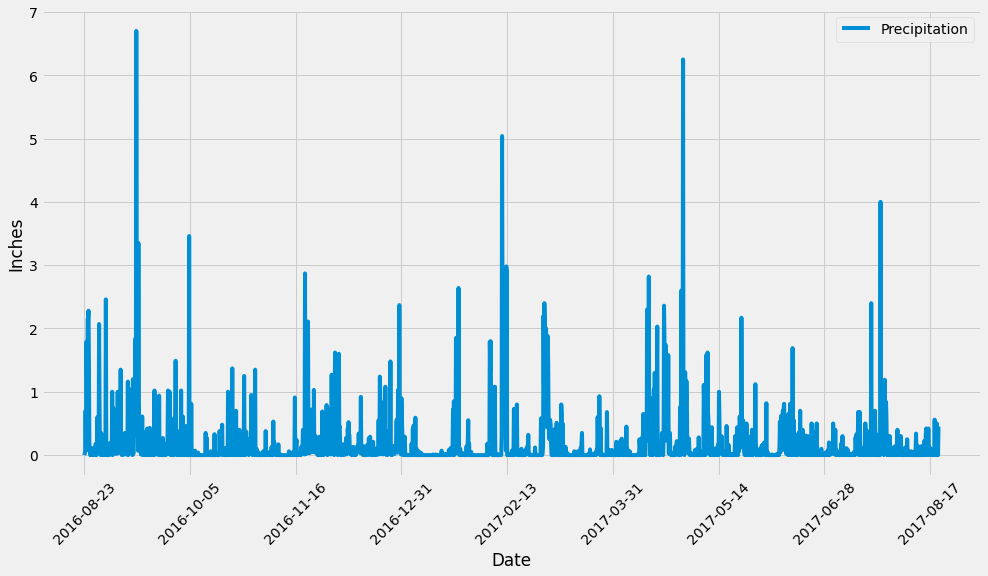

In [106]:
# Perform a query to retrieve the data and precipitation scores
data=engine.execute('SELECT station,prcp,id,date,tobs FROM measurement WHERE date>="2016-08-23"').fetchall()
# Save the query results as a Pandas DataFrame and set the index to the date column
measurement_df=pd.DataFrame(data)

measurement_df.columns = ('Station','Precipitation','ID','Date','TOBS')



# Sort the dataframe by date

clean_measurement_df=measurement_df.set_index('Date').dropna()

sorted_measurement_df=clean_measurement_df.sort_values(by='Date',ascending=True)


# Use Pandas Plotting with Matplotlib to plot the data

sorted_measurement_df.plot(y='Precipitation',figsize=(15,8))
plt.xticks(rotation=45)
plt.ylabel('Inches')
Plt


In [92]:
clean_measurement_df.head()

,station,prcp,id,tobs
date,,,,
2016-08-23,USC00519397,0.00,2364,81.0
2016-08-24,USC00519397,0.08,2365,79.0
2016-08-25,USC00519397,0.08,2366,80.0
2016-08-26,USC00519397,0.00,2367,79.0
2016-08-27,USC00519397,0.00,2368,77.0


(array([-250.,    0.,  250.,  500.,  750., 1000., 1250., 1500., 1750.,
        2000., 2250.]),
 [Text(-250.0, 0, '2016-11-11'),
  Text(0.0, 0, '2016-08-23'),
  Text(250.0, 0, '2017-05-02'),
  Text(500.0, 0, '2017-01-11'),
  Text(750.0, 0, '2016-10-29'),
  Text(1000.0, 0, '2017-02-23'),
  Text(1250.0, 0, '2017-05-09'),
  Text(1500.0, 0, '2017-01-29'),
  Text(1750.0, 0, '2016-10-21'),
  Text(2000.0, 0, '2017-07-26'),
  Text(2250.0, 0, '')])

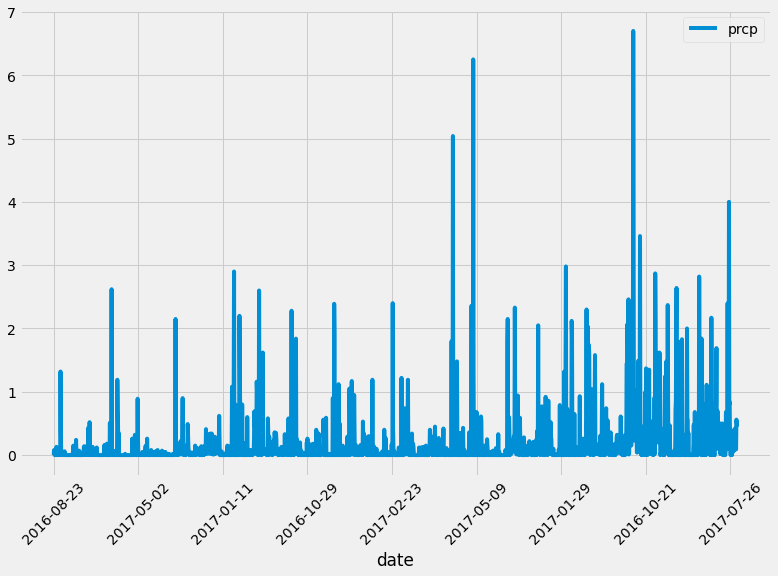

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data

In [18]:
# Design a query to show how many stations are available in this dataset?


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


## Bonus Challenge Assignment

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

NameError: name 'Measurement' is not defined

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
